In [42]:
%matplotlib inline

from __future__ import division

import numpy as np

import matplotlib.pyplot as pl
from matplotlib.mlab import griddata

from matplotlib import colors, ticker, cm

from scipy.integrate import odeint
from scipy.special import erf

Let's use a planar coordinate system (everything has z = 0), so we just have two coordinates (x,y). If we have a position array x, then let's say that x[0] = x, x[1] = y.

### Some constants

We're operating in units of (parsecs), (solar masses) and (km/s).
Time is in units of parsec/(km/s) = 3.086e13 s = 0.978 Myr.

In [43]:
G_N = 4.302e-3 #(pc/solar mass) (km/s)^2   #4.2998?
M_PBH = 30.0

r_tr = 0.0063*(M_PBH**(1.0/3.0))

A = 3*M_PBH/(8*np.pi*r_tr**3)
T = 0.978 #Myr

common_halo = 1

### Some random functions

Mass enclosed in the halo at a given distance:

In [44]:
#Mass of PBH + DM within a radius r
def Menc(r):
    if (common_halo == 1):
        mass = 2.*M_PBH
    else:
        mass = M_PBH
        
    #mass = mass/1.e6    
        
    if (r > r_tr):
        return 1.0*(mass)   #use the accurate formula?
    else:
        return mass*(r/r_tr)**(3/2)   #factor of 2 for common halo case

In [45]:
def density(r):
    if (r > r_tr):
        return 0   #use the accurate formula?
    else:
        return A*(r/r_tr)**(-3.0/2.0)

Gravitational force

In [46]:
def F_grav_complete(x,x2):
    
    r = np.sqrt(x[0]**2 + x[1]**2)
    F_grav_common_halo = -x*G_N*Menc(r)*M_PBH/r**3
    
    r2 = np.sqrt((x[0]-x2[0])**2. + (x[1]-x2[1])**2.)
    F_grav_other_black_hole = -(x-x2)*G_N*M_PBH*M_PBH/(r2**3.)
    
    return  1.*F_grav_common_halo + F_grav_other_black_hole


def F_grav(x,v):
    r = np.sqrt(x[0]**2 + x[1]**2)    
    return -x*G_N*Menc(r)*M_PBH/r**3 

Dynamical friction force:

In [47]:
#Correction due to the speed distribution of DM in the halo
#Assume for now some kind of Maxwell-Boltzmann distribution
def dist_corr(r, v_abs):
    #TODO: use the X corresponding to the actual velocity distribution at that R
    #disp = np.sqrt(2*G_N*Menc(r)/r) #Within some factor
    #X = v_abs/np.sqrt(2)
    X = v_abs/np.sqrt(2.*G_N*Menc(r)/r)
    return erf(X) - (2*X/np.sqrt(np.pi))*np.exp(-X**2)

In [48]:
#See, for example, https://arxiv.org/pdf/1604.02034.pdf
#For now, take the coulomb logarithm to be equal to 1 (we can discuss, see also 1009.2455)

def F_dyn(x,v):
    
    r = np.sqrt(x[0]**2 + x[1]**2)
    v_abs = np.sqrt(v[0]**2 + v[1]**2)
    norm = 4*np.pi*((M_PBH)**2)*(G_N**2)   #Extra factor of M_PBH appears here because this is the force
    ###
    Dr = (2./3.)*r
    a90 = G_N*M_PBH/(v_abs**2.+(2.*G_N*Menc(r)/r))
    coulomb_log = 1.#np.log( Dr/a90 )
    ###
    return -norm*v*density(r)*dist_corr(r, v_abs)*coulomb_log/v_abs**3 
    # ln (Lambda)  = 1  ?

#This should come out with the correct units (M_solar (km/s)/T)

### Set up the system and solve the ODE:

In [57]:
e = 0.9
a = 0.1*r_tr

P = 2*np.pi*np.sqrt(a**3/(2*M_PBH*G_N))

r0 = (1+e)*a
x1_init = [ r0/2,  0.]
x2_init = [-r0/2., 0.]

v_apo = 0.5 * np.sqrt( (1.-e)*2.*G_N*M_PBH/((1.+e)*a) )
v1_init = [0, v_apo]
v2_init = [0, -v_apo]

s_init = np.append(x1_init, x2_init) 
s_init = np.append(s_init, v1_init)
s_init = np.append(s_init, v2_init)

In [58]:
#Derivative. Here s is the combined phase space coordinates: s[0] = x, s[1] = y, s[2] = v_x, s[3] = v_y
def dsdt(s, t):
    
    ds = s*0.0
    
    #Derivative of the position is the speed...Easy!
    ds[0] = s[4]
    ds[1] = s[5]
    ds[2] = s[6]
    ds[3] = s[7]
    
    x1 = s[0:2]
    x2 = s[2:4]
    v1 = s[4:6]
    v2 = s[6:8]
    
    #Calculate acceleration:
    
    force1 = F_grav_complete(x1,x2) + 1.*F_dyn(x1, v1)
    ds[4] = force1[0]/M_PBH
    ds[5] = force1[1]/M_PBH
    force2 = F_grav_complete(x2,x1) + 1.*F_dyn(x2, v2)
    ds[6] = force2[0]/M_PBH
    ds[7] = force2[1]/M_PBH
    
    return ds
    

In [59]:
#Run for a little over half a period
tvals = np.linspace(0, 2.5*P, 10000)

ode_result = odeint(dsdt, s_init, tvals)

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/scipy/integrate/odepack.py:218: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  warnings.warn(warning_msg, ODEintWarning)


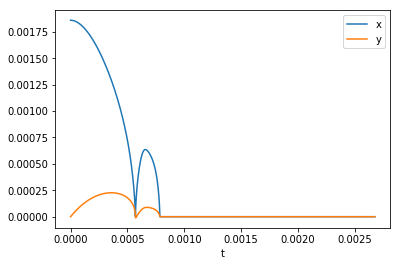

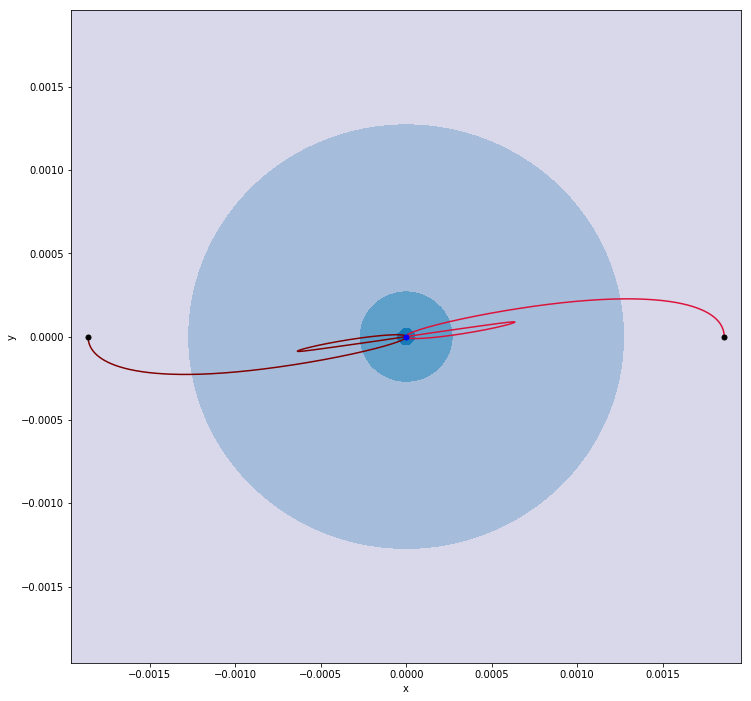

In [60]:
#plot x and y as a function of t
pl.figure()
pl.plot(tvals, ode_result[:,0], label="x")
pl.plot(tvals, ode_result[:,1], label="y")
pl.xlabel("t")
pl.legend()

#Trace the orbit
f = pl.figure(figsize=(12,12))
pl.plot(ode_result[:,0], ode_result[:,1], color="crimson")
pl.plot(ode_result[:,2], ode_result[:,3], color="maroon")

pl.plot([0.0,0.0], 'bo', ms=5.0)
pl.plot(x1_init[0], x1_init[1], 'ko',ms=5.0)
pl.plot(x2_init[0], x2_init[1], 'ko',ms=5.0)

pl.xlabel("x")
pl.ylabel("y")

xmax = 0.10
ymax = 0.10

pl.xlim(-r_tr*xmax, r_tr*xmax)
pl.ylim(-r_tr*ymax, r_tr*ymax)

circle1 = pl.Circle((0, 0), r_tr, color='b', linestyle='--',linewidth=2.0, fill=False)
npts = 100
xi_vec = np.linspace(-r_tr*xmax, r_tr*xmax, npts)
yi_vec = np.linspace(-r_tr*ymax, r_tr*ymax, npts)
Xi_vec, Yi_vec = np.meshgrid(xi_vec, yi_vec)
Zi_vec = np.zeros((npts,npts))
ind = 0
for ix in range(npts):
    for iy in range(npts):
        Zi_vec[ix,iy] = Menc( np.sqrt(xi_vec[ix]**2. + yi_vec[iy]**2.) )  
        ind += 1
CS = pl.contourf(Xi_vec, Yi_vec, Zi_vec, locator=ticker.LogLocator(), cmap=cm.PuBu_r)


ax = f.gca()
ax.add_artist(circle1)


pl.show()

put comments here

### Calculating the eccentricity

In [71]:
def specific_energy(r, v_abs):    
    return 0.5*v_abs**2 - (G_N*(M_PBH)/r)

def specific_angmom(x,v):
    h = np.cross(x,v)
    return np.sqrt(np.sum(h**2))

def ecc(s):
    
    x1 = s[0:2]
    x2 = s[2:4]
    v1 = s[4:6]
    v2 = s[6:8]    
    
    r = np.sqrt(np.sum((x1-x2)**2))
    v_abs = np.sqrt(np.sum((v1-v2)**2))
    
    eps = specific_energy(r, v_abs)
    h = specific_angmom(x1-x2,v1-v2)
    mu = G_N*M_PBH
    
    return np.sqrt(1.0 + 2.0*eps*h**2/mu**2)

In [72]:
ecc_list = np.zeros(len(tvals))
for i in range(len(tvals)):
    ecc_list[i] = ecc(ode_result[i,:])

/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:2: RuntimeWarning: divide by zero encountered in double_scalars
  
/Library/Frameworks/Python.framework/Versions/3.5/lib/python3.5/site-packages/ipykernel_launcher.py:22: RuntimeWarning: invalid value encountered in double_scalars


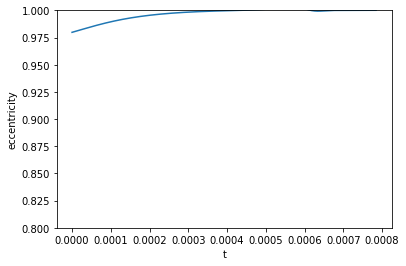

In [70]:
pl.figure()
pl.plot(tvals, ecc_list)
pl.ylabel("eccentricity")
pl.xlabel("t")
pl.ylim(0.8, 1)
pl.show()